In [1]:
import os
from google.colab import drive  # Google Drive support
drive.mount('/content/drive')   # Mount Google Drive

Mounted at /content/drive


# Assignment 1

**1. Define Path**

In [2]:
# Train set path
train_path = '/content/drive/MyDrive/COS30082/A1/train'
test_path = '/content/drive/MyDrive/COS30082/A1/test'

**2. Image Processing**

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

# List of class names
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# Load file paths and labels
file_paths = []
labels = []

# Enumerate classes name
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    for fname in os.listdir(class_folder):
        file_paths.append(os.path.join(class_folder, fname))
        labels.append(class_name)

# Split traub set into train/val sets (80/20 proportionally)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=SEED)

# Apply processing and augumentation on train/val data
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1./255)

# Load and label the images for train/val set
train_data = train_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True)
val_data = val_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename', y_col='class',
    target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)


Found 8006 validated image filenames belonging to 10 classes.
Found 2002 validated image filenames belonging to 10 classes.


**3. Build and TrainCNN Models**

*a. Base CNN*

In [4]:
def build_cnn_base():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

*b. CNN with Dropout & Augmentation*

In [5]:
def build_cnn_augmentation():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

*c. Train CNN models*

In [6]:
# Train models
model_base = build_cnn_base()
model_augmentation = build_cnn_augmentation()

# Train models by 20 epochs and record metrics by each epoch
history_base = model_base.fit(train_data, epochs=20, validation_data=val_data)
print("Base model training completed")
history_augmentation = model_augmentation.fit(train_data, epochs=20, validation_data=val_data)
print("Processed model training completed")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3169s 13s/step - accuracy: 0.1364 - loss: 2.5380 - val_accuracy: 0.2218 - val_loss: 2.2017
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 513ms/step - accuracy: 0.2470 - loss: 2.0997 - val_accuracy: 0.2822 - val_loss: 2.0419
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 516ms/step - accuracy: 0.2932 - loss: 1.9917 - val_accuracy: 0.3012 - val_loss: 1.9875
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 519ms/step - accuracy: 0.2967 - loss: 1.9600 - val_accuracy: 0.2987 - val_loss: 2.0164
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 513ms/step - accuracy: 0.3277 - loss: 1.9226 - val_accuracy: 0.3122 - val_loss: 1.9532
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 515ms/step - accuracy: 0.3319 - loss: 1.9001 - val_accuracy: 0.3157 - val_loss: 2.0046
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 514ms/step - accuracy: 0.3634 - loss: 1.8368 - val_accuracy: 0.3317 - val_loss: 1.9497
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 515ms/step - accuracy: 0.3713 - 

**4. Evaluate Models**

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Predict on validation data
val_data.reset()
y_true = val_data.classes

# Examine prediction accuracy by each models on val set
ybase_pred_probs = model_base.predict(val_data)
yaug_pred_probs = model_augmentation.predict(val_data)
ybase_pred = np.argmax(ybase_pred_probs, axis=1)
yaug_pred = np.argmax(yaug_pred_probs, axis=1)

# Top 1 Accuracy
top1_acc_base = accuracy_score(y_true, ybase_pred)
print(f"Top-1 Accuracy for Base Model: {top1_acc_base:.4f}")
top1_acc_aug = accuracy_score(y_true, yaug_pred)
print(f"Top-1 Accuracy for Augmented Model: {top1_acc_aug:.4f}")

# Average Accuracy per Class
report_base = classification_report(y_true, ybase_pred, target_names=class_names, output_dict=True)
avg_class_acc_base = np.mean([report_base[cls]['recall'] for cls in class_names])
print(f"Average Accuracy per Class for Base Model: {avg_class_acc_base:.4f}")
report_aug = classification_report(y_true, yaug_pred, target_names=class_names, output_dict=True)
avg_class_acc_aug = np.mean([report_aug[cls]['recall'] for cls in class_names])
print(f"Average Accuracy per Class for Augmented Model: {avg_class_acc_aug:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 320ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step
Top-1 Accuracy for Base Model: 0.3556
Top-1 Accuracy for Augmented Model: 0.3352
Average Accuracy per Class for Base Model: 0.3556
Average Accuracy per Class for Augmented Model: 0.3350


**5. Visualization** (Learning Curve)

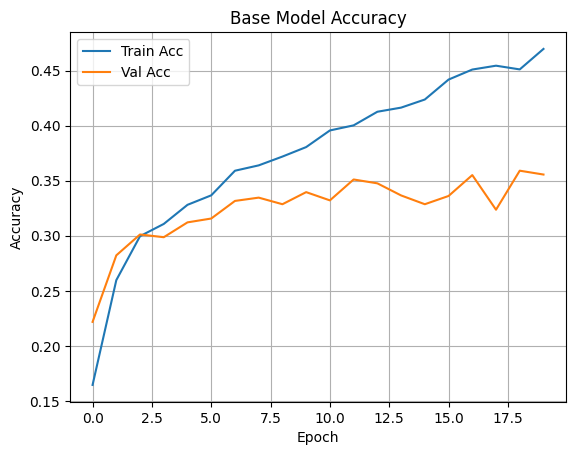

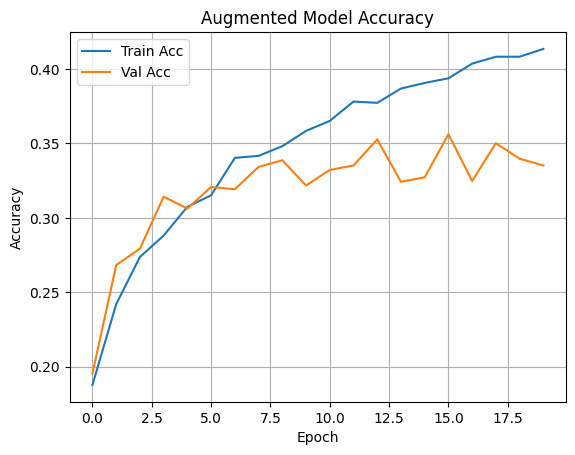

In [10]:
import matplotlib.pyplot as plt

plt.plot(history_base.history['accuracy'], label='Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Val Acc')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history_augmentation.history['accuracy'], label='Train Acc')
plt.plot(history_augmentation.history['val_accuracy'], label='Val Acc')
plt.title('Augmented Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**6. Test Prediction from Test-set**

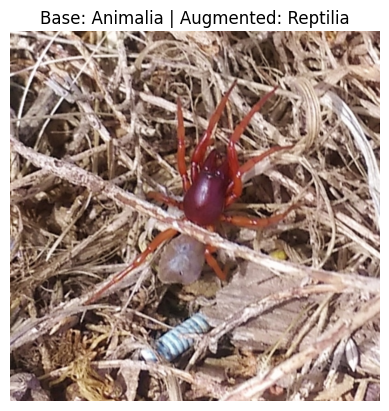

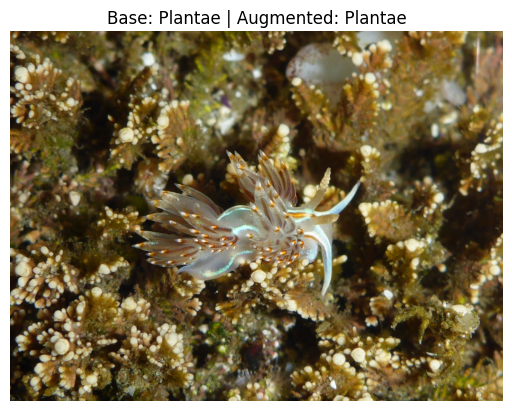

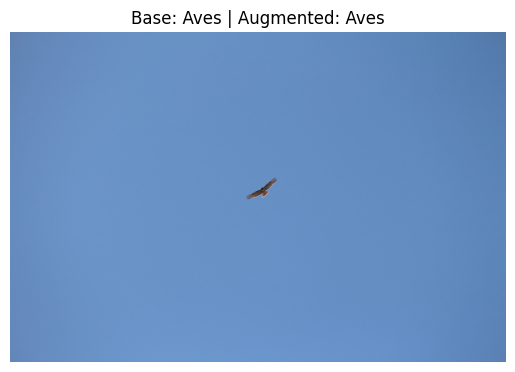

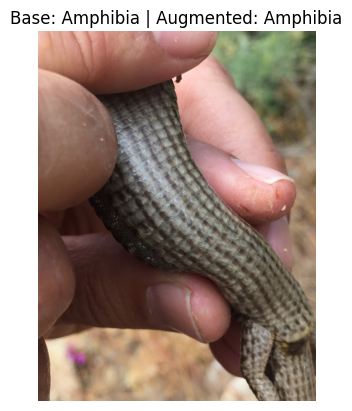

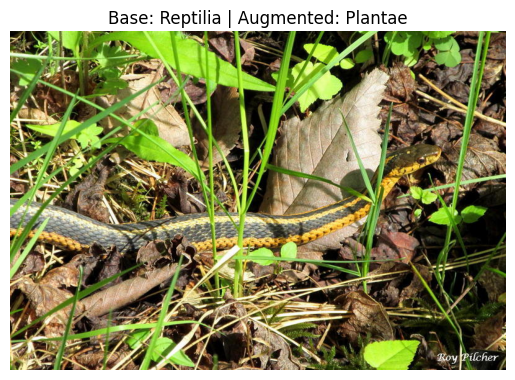

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

IMG_SIZE = (128, 128)
class_names = list(train_data.class_indices.keys())

# Randomly select 5 test images
random_images = random.sample(os.listdir(test_path), 5)
image_paths = [os.path.join(test_path, img) for img in random_images]

# Process images (similar to training)
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)  # add batch dimension

# Prediction
for path in image_paths:
    img_batch = preprocess_image(path)
    # Use both models
    pred_base = model_base.predict(img_batch, verbose=0)
    pred_aug = model_augmentation.predict(img_batch, verbose=0)
    # Extract class name
    class_base = class_names[np.argmax(pred_base)]
    class_aug = class_names[np.argmax(pred_aug)]
    # Display
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Base: {class_base} | Augmented: {class_aug}")
    plt.show()


**7. Save to Drive**

In [ ]:
# Path
model_path = '/content/drive/MyDrive/COS30082/A1/model'

# Save the base model
model_base.save(f"{model_path}/cnn_base_model.h5")
print("Base model saved.")

# Save the augmentation model
model_augmentation.save(f"{model_path}/cnn_augmented_model.h5")
print("Augmented model saved.")